# Lesson 2: Tool Calling

## Setup

In [1]:
from helper import get_openai_api_key
OPENAI_API_KEY = get_openai_api_key()

In [2]:
import nest_asyncio
nest_asyncio.apply()

## 1. Define a Simple Tool

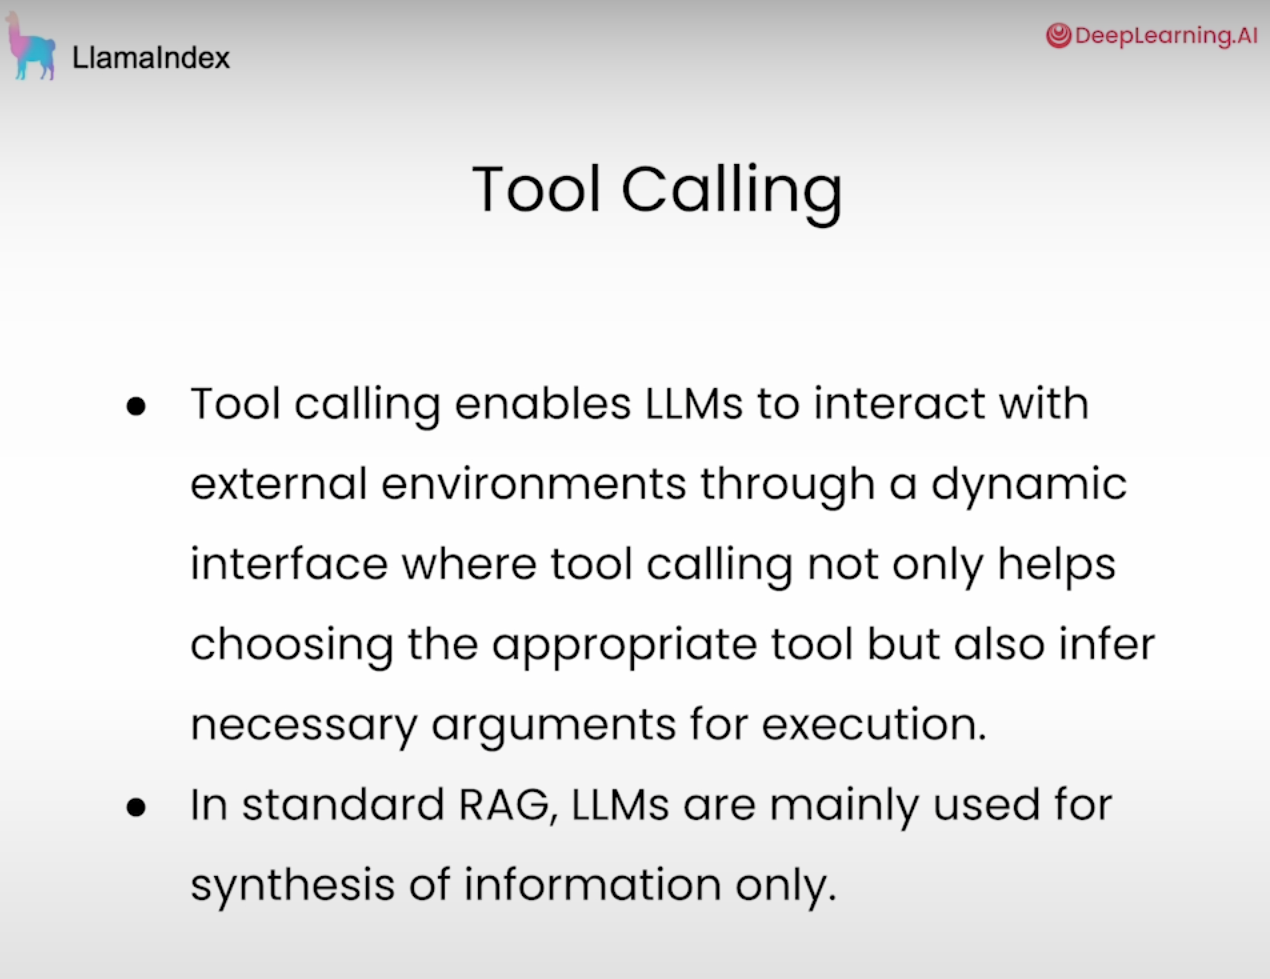

In [3]:
from llama_index.core.tools import FunctionTool

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: int, y: int) -> int: 
    """Mystery function that operates on top of two numbers."""
    return (x + y) * (x + y)


add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

In [4]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")
response = llm.predict_and_call(
    [add_tool, mystery_tool], 
    "Tell me the output of the mystery function on 2 and 9", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": 2, "y": 9}
=== Function Output ===
121
121


## 2. Define an Auto-Retrieval Tool

### Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [5]:
from llama_index.core import SimpleDirectoryReader
# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

In [6]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [7]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-09-30
last_modified_date: 2024-06-24

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, however, 

In [8]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(nodes)
query_engine = vector_index.as_query_engine(similarity_top_k=2)

In [9]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

In [10]:
print(str(response))

MetaGPT achieves a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. It stands out in handling higher levels of software complexity and offering extensive functionality. In experimental evaluations, MetaGPT achieves a 100% task completion rate, demonstrating robustness and efficiency in terms of time and token costs.


In [11]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-09-30', 'last_modified_date': '2024-06-24'}


### Define the Auto-Retrieval Tool

In [12]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(
    query: str, 
    page_numbers: List[str]
) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]
    
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response
    

vector_query_tool = FunctionTool.from_defaults(
    name="vector_tool",
    fn=vector_query
)

In [13]:
llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
=== Function Output ===
MetaGPT achieves a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. It stands out in handling higher levels of software complexity and offering extensive functionality, demonstrating a 100% task completion rate in experimental evaluations.


In [14]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-09-30', 'last_modified_date': '2024-06-24'}


## Let's add some other tools!

In [15]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [16]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT outperforms ChatDev on the challenging SoftwareDev dataset in nearly all metrics. For example, MetaGPT achieves a higher score in executability, takes less time for software generation, uses more tokens but requires fewer tokens to generate one line of code compared to ChatDev. Additionally, MetaGPT demonstrates autonomous software generation capabilities and highlights the benefits of using SOPs in collaborations between multiple agents.


In [17]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-09-30', 'last_modified_date': '2024-06-24'}


In [18]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

=== Calling Function ===
Calling function: summary_tool with args: {"input": "The paper discusses the impact of climate change on biodiversity and ecosystems."}
=== Function Output ===
The paper does not discuss the impact of climate change on biodiversity and ecosystems.
